<a href="https://colab.research.google.com/github/Ann-Helen/machinelearning_masterthesis/blob/master/30_days.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preparation

## File Management & Imports

In [466]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [467]:
# FILE MANAGEMENT (get .csv from drive)
# GENERAL
import numpy as np
from numpy import hstack, array
from numpy import asarray
from numpy import split
import pandas as pd

!pip install keras.utils
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.animation import FuncAnimation
from math import sqrt
import seaborn as sns

# Visualizations
import matplotlib.pyplot as plt
# !pip install matplotlib
#%matplotlib notebook
%matplotlib inline
sns.set_context("paper")
import warnings
from scipy.stats import pearsonr, describe

# KERAS
%tensorflow_version 2.x
import tensorflow
print(tensorflow.__version__)
!pip install keras.utils plot_model
# from keras.utils import plot_model  # Converts a Keras model to dot format and save to a file
# from keras.models import Model
# from keras.layers import Input    # used to instantiate a Keras tensor
from keras.layers import Dense    # Create layers
from keras.layers import Flatten  # Flattens tensor to vector
from keras.layers.convolutional import Conv1D # D convolution
from keras.layers.convolutional import MaxPooling1D # Max pooling operation for X data
from keras.layers import Dropout
# from keras.layers.merge import concatenate
from keras.models import Sequential
from keras.callbacks import EarlyStopping, TerminateOnNaN

from sklearn import preprocessing
#from sklearn.preprocessing import MinMaxScaler

2.6.0


## Version Checking

In [468]:
# check the versions of key python libraries
print('')
print('============================================')
print('Check the versions of key python libraries: ')
# scipy
import scipy
print('scipy: %s' % scipy.__version__)
# numpy
import numpy
print('numpy: %s' % numpy.__version__)
# matplotlib
import matplotlib
print('matplotlib: %s' % matplotlib.__version__)
# pandas
import pandas
print('pandas: %s' % pandas.__version__)
# statsmodels
import statsmodels
print('statsmodels: %s' % statsmodels.__version__)
# scikit-learn
import sklearn
print('sklearn: %s' % sklearn.__version__)


Check the versions of key python libraries: 
scipy: 1.4.1
numpy: 1.19.5
matplotlib: 3.2.2
pandas: 1.1.5
statsmodels: 0.10.2
sklearn: 0.22.2.post1


# Multi-step Multichannel

In [469]:
############### MULTI-STEP MULTICHANNEL ##############
# Here we test using all the time series.
#
# This is done by providing each one-dimensional time series to the model
# as a separate channel of input (hence multi-channel).

# The CNN will then use a separate kernel and read each unput sequence
# onto a separate set of filter maps, essentially learning features from
# each input time series variable.

# This is helpful cause we have multiple features we need to do calculations
# on, not just the one feature we want as output.
######################################################

## split_dataset()

In [470]:
# split a univariate dataset into train/test sets
def split_dataset(data):
  # split into standard weeks
  print(len(data))
  train, test = data[1:-284], data[-306:-6]#-328 -306 for BTC
  # restructure into windows of weekly/monthly data
  print("Pre-split train: ")
  print(train.shape)
  print("Pre-split test: ")
  print(test.shape)
  train = array(split(train, len(train)/30))#7
  test = array(split(test, len(test)/30))
  print("Post-split train: ")
  print(train.shape)
  print("Post-split test: ")
  print(test.shape)
  return train, test

## evaluate_forecasts()

In [471]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

## summarize_scores()

In [472]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

## to_supervised()

In [473]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=30):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			#This differs from univariate. Here we make sure to take the whole dataset.
			X.append(data[in_start:in_end, :])
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

## build_model()

In [474]:
# train the model
def build_model(train, n_input):
	global CLEAN_RUN
	CLEAN_RUN = True
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
 	# define parameters
	verbose, epochs, batch_size = 1, 70, 30
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# define model
	kernel = 3
	model = Sequential()
	model.add(Conv1D(filters=3, kernel_size=kernel, activation='relu', input_shape=(n_timesteps,n_features)))
	model.add(Conv1D(filters=5, kernel_size=kernel,  activation='relu'))
	model.add(MaxPooling1D(pool_size=2, strides = 2))
	model.add(Conv1D(filters=7, kernel_size=kernel, activation='relu'))
	model.add(Conv1D(filters=15, kernel_size=kernel, activation='relu'))
	model.add(MaxPooling1D(pool_size=2, strides = 2))
	model.add(Conv1D(filters=32, kernel_size=kernel, activation='relu'))
	model.add(Conv1D(filters=50, kernel_size=kernel, activation='relu'))
	model.add(Conv1D(filters=64, kernel_size=kernel, activation='relu'))
	model.add(MaxPooling1D(pool_size=2, strides = 2))
	#model.add(Dropout(0.5))
	model.add(Flatten())
	model.add(Dense(100, activation='sigmoid')) #needed
	model.add(Dense(50))
	model.add(Dense(16))
	model.add(Dense(n_outputs))
	model.compile(loss='mse', optimizer='adam', metrics = ['accuracy','mean_squared_error'])
	print(model.summary())
	# fit network
	callbacks = [
		EarlyStopping(
			# Stop training when `val_loss` is no longer improving
			monitor='val_loss',
      # "no longer improving" being defined as "no better than 1e-2 less"
      min_delta=1e-2,
      # "no longer improving" defined as "for at least 2 epochs"
      patience=10,
      verbose=1,
			#restore_best_weights = True  # This could make it worse!
    ),
    TerminateOnNaN() # Stops training if loss = NaN
  ]
	print(n_features)
	if CLEAN_RUN:
		# Only allows training if training has not been run
		history = model.fit(
				train_x, 
				train_y, 
				validation_split = 0.2, 
				epochs=epochs, 
				batch_size=batch_size, 
				verbose=verbose, 
				callbacks = callbacks)
		CLEAN_RUN = False # Prevents double-training
	elif not CLEAN_RUN:
		print("Session is not CLEAN_RUN. Use Colab 'Run all'!")
	print("\n___MODEL LOSS___")
	print("Final MSE:   ", history.history['mean_squared_error'][-1])
	plt.plot(history.history['mean_squared_error']) #previously 'loss'
	plt.plot(history.history['val_mean_squared_error']) #previously 'val_loss'
	plt.title('Model loss')
	plt.ylabel('Loss value')
	plt.xlabel('Epoch')
	plt.legend(['Training', 'Keras.validation_split (verify training using x%)'], loc='best')
	plt.show()
	return model

## forecast()

In [475]:
# Make a forecast.
def forecast(model, history, n_input):
  # flatten data
  data = array(history)
  data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
  # retrieve last observations for input data
  # For multivariate, make sure to use all features.
  input_x = data[-n_input:, :]
  # reshape into [1, n_input, n]
  # We need to change the shape as well to take all features.
  input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
  # forecast the next week
  yhat = model.predict(input_x, verbose=0)
  # we only want the vector forecast
  yhat = yhat[0]
  return yhat

## evaluate_model()

In [476]:
# evaluate a single model
def evaluate_model(train, test, n_input):
  print("Fitting model...")
  # Replace NaN with mean values.
  print("Fix NaN values in train...")
  col_mean = np.nanmean(train, axis=0)
  inds = np.where(np.isnan(train))
  train[inds] = np.take(col_mean, inds[1])
  #train_has_nan = np.isnan(train)
  #print("Does train contain NaN values? ", train_has_nan)
  #test_has_nan = np.isnan(test)
  #print("Does test contain NaN values? ", test_has_nan)
  # fit model
  model = build_model(train, n_input)

  # history is a list of weekly data
  history = [x for x in train]
  # walk-forward validation over each week
  predictions = list()
  for i in range(len(test)):
    #print("Round: ", i+1)
    # predict the week
    yhat_sequence = forecast(model, history, n_input)
    # store the predictions
    predictions.append(yhat_sequence)
    # get real observation and add to history for predicting the next week
    history.append(test[i, :])
  # evaluate predictions days for each week
  predictions = array(predictions)
  score, scores = evaluate_forecasts(test[:, :, 0], predictions)
  return score, scores

## Import & Normalising Data

In [477]:
# IMPORT & NORMALIZE DATA
#URL = 'https://raw.githubusercontent.com/victordahl/dataset/master/MSFT_10yrs.csv'
#URL = 'https://raw.githubusercontent.com/victordahl/dataset/master/MSFT_10yrs_open.csv'
#dataset = read_csv('/content/drive/MyDrive/Thesis/BTC-USD.csv', header=0, infer_datetime_format=True, parse_dates=['Date'], index_col=['Date'])
dataset = read_csv('/content/drive/MyDrive/Thesis/MSFT_10yrs.csv')
#print("cvs type", type(csvfile))

#print(csvfile.iloc[:, 1:]) 
min_max_scaler = preprocessing.MinMaxScaler()

# Normalize last five columns (excluding date in first columns)
x_scaled = min_max_scaler.fit_transform(dataset.iloc[:, 1:])
df = pd.DataFrame(x_scaled)
# Rename all columns
print(df)
df.columns = ["Open","High","Low","Close","Volume"]
df.fillna(df.mean(), inplace=True)

# Derived features
short_SMA = 50
long_SMA = 200
df["50SMA"] = df["Open"].rolling(window=short_SMA).mean()
df["200SMA"] = df["Open"].rolling(window=long_SMA).mean()
# Trim head of dataset to remove the NaN days in SMA feature head
df = df.iloc[132:]#132


             0         1         2         3         4
0     0.047923  0.049349  0.048369  0.047981  0.454772
1     0.047207  0.047527  0.049652  0.048886  0.214303
2     0.046909  0.047377  0.048976  0.047287  0.233660
3     0.046730  0.045884  0.048186  0.047679  0.217432
4     0.046789  0.048472  0.048492  0.048241  0.171891
...        ...       ...       ...       ...       ...
2512  0.902423  0.919823  0.917125  0.929628  0.164116
2513  0.933457  0.936074  0.935263  0.939043  0.172830
2514  0.916328  0.928606  0.929889  0.917678  0.111474
2515  0.897649  0.898255  0.875658  0.873982  0.185935
2516  0.885056  0.900227  0.904422  0.908383  0.103782

[2517 rows x 5 columns]


## Visualisation of Data

              Open         High          Low        Close       Volume
count  2385.000000  2385.000000  2385.000000  2385.000000  2385.000000
mean      0.234333     0.236553     0.238422     0.237595     0.116364
std       0.229894     0.232563     0.232488     0.232515     0.081384
min       0.003939     0.004122     0.005619     0.004195     0.000000
25%       0.050430     0.051261     0.052034     0.051904     0.062125
50%       0.144486     0.145836     0.147001     0.146901     0.096201
75%       0.365720     0.368008     0.373153     0.370934     0.151031
max       1.000000     1.000000     1.000000     1.000000     1.000000 

             50SMA       200SMA
count  2385.000000  2318.000000
mean      0.226017     0.206818
std       0.222263     0.197972
min       0.009808     0.015547
25%       0.046178     0.041663
50%       0.138495     0.133113
75%       0.342271     0.304412
max       0.872307     0.763745 

plotting Open...
plotting High...
plotting Low...
plotting Close...
p

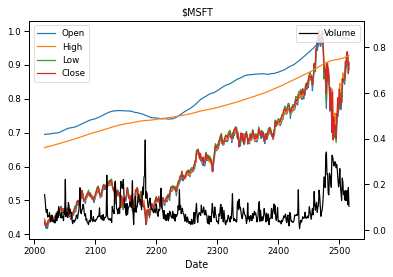

In [478]:
# describe and visualize data
print(df.iloc[:, 0:5].describe(),"\n")
print(df.iloc[:, 5:].describe(),"\n")

#tail = int(input("Print tail:"))
tail=500
fig, ax1 = plt.subplots()
#plt.title("$BTC-USD")
plt.title("$MSFT")
plt.xlabel("Date")

df_columns = []
for i in df.columns:
  if i != "Volume":
    print("plotting {}...".format(i))
    plt.plot(df[i].tail(tail), label=i)
    ax1.legend(loc=2)
  elif i == "Volume":
    # Put 'Volume' on second Y axis for better plot
    print("plotting {}...".format(i))
    ax2 = ax1.twinx()
    ax2.plot(df[i].tail(tail), 'k', label=i)
    ax2.legend(loc=1)

## Dataset information

In [479]:
# DATASET
SET_SIZE = 2100
raw_train_set = df.iloc[0:SET_SIZE]
raw_test_set = df.iloc[SET_SIZE:len(df)]
assert(len(raw_train_set)==SET_SIZE), "Something wrong with dataset separation..."
historic = []

## Results...

2385
Pre-split train: 
(2100, 7)
Pre-split test: 
(300, 7)
Post-split train: 
(70, 30, 7)
Post-split test: 
(10, 30, 7)
Fitting model...
Fix NaN values in train...
Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_130 (Conv1D)          (None, 58, 3)             66        
_________________________________________________________________
conv1d_131 (Conv1D)          (None, 56, 5)             50        
_________________________________________________________________
max_pooling1d_73 (MaxPooling (None, 28, 5)             0         
_________________________________________________________________
conv1d_132 (Conv1D)          (None, 26, 7)             112       
_________________________________________________________________
conv1d_133 (Conv1D)          (None, 24, 15)            330       
_________________________________________________________________
max_pooling1d_74 (Max

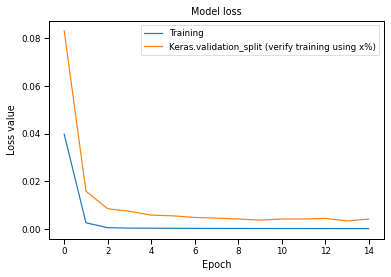

cnn: [0.217] 0.2, 0.3, 0.3, 0.3, 0.2, 0.1, 0.2, 0.1, 0.2, 0.2, 0.2, 0.3, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 0.2, 0.2, 0.2, 0.2, 0.2, 0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.2
   Prediction  Historic
0   64.945024    157.13 
Similarity: 41.33 %


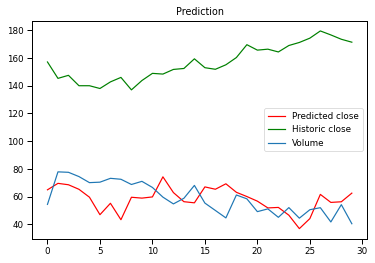

In [480]:
# Fix for eventual bugs with running in Colab.
train, test = split_dataset(df.values)
# evaluate model and get scores
n_input = 60
score, scores = evaluate_model(train, test, n_input)

# summarize scores
summarize_scores('cnn', score, scores)
tail = df.iloc[:, :-6].tail(len(scores))
tail = tail.to_numpy()
tail = array(tail).reshape(-1, 1)
volume = df['Volume'].tail(len(scores))
volume = volume.to_numpy()
volume = array(volume).reshape(-1, 1)

# Reset scaler
set_new_scaled = min_max_scaler.fit_transform(dataset.iloc[:, [1]])

# Denormalize
scores = array(scores).reshape(-1, 1)
scores = min_max_scaler.inverse_transform(scores)
historic = min_max_scaler.inverse_transform(tail)
volume = min_max_scaler.inverse_transform(volume)
compare_df = pd.DataFrame({
    'Prediction': scores[0],
    'Historic': historic[0]
    })
print(compare_df, "\nSimilarity:",round(*(scores[0]/historic[0])*100,2),"%")
#print("\nPrediction:")
#print(prediction)

# plot scores
#days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat', 'sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat', 'sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat', 'sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat', 'sun', 'mon']
#['1', '2', '3', '4', '5', '6', '7']#, '8', '9', '10', '11', '12', '13', '14','15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30']
plt.title("Prediction")
#plt.plot(scores, marker='o', label='Predicted close')
plt.plot(scores,color='red', label='Predicted close')
plt.plot(historic, color='green', label='Historic close')
plt.plot(volume, label='Volume')
plt.legend()
plt.show()